In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import bokeh.plotting as blt
import bokeh
bokeh.io.output_notebook()
from numba import jit
%load_ext Cython
%load_ext line_profiler
%matplotlib inline

Loading BokehJS ...

In [3]:
#this allows line profiler (via ipython magic %lprun) to profile cython functions
from Cython.Compiler.Options import get_directive_defaults

get_directive_defaults()['linetrace'] = True
get_directive_defaults()['binding'] = True

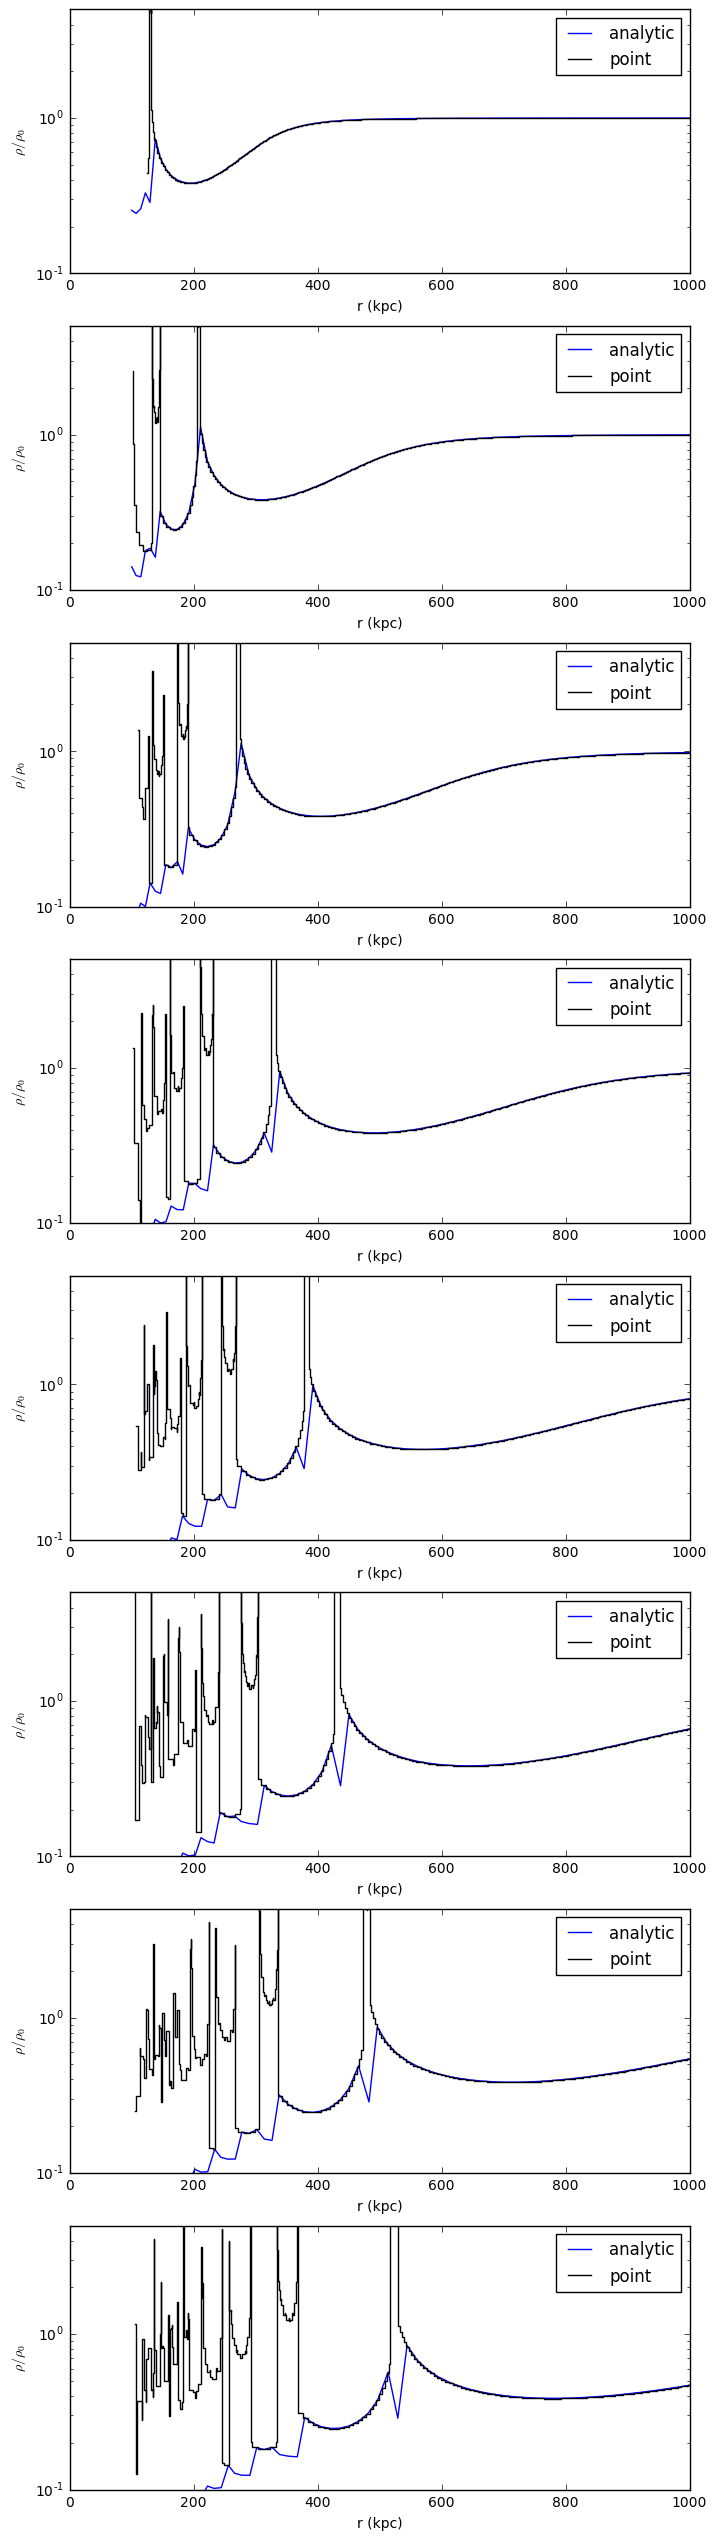

In [89]:
#plot density profiles
from matplotlib import gridspec

fig=plt.figure(figsize=(8,32))
grid=gridspec.GridSpec(8,1)
cmap = matplotlib.cm.get_cmap('inferno')

plotRads=np.linspace(minR,maxR,2000)

for step in range(nTimeStep):
    if (addAnalytic==1):
        getAnalyticPlot(analyticRs[step,:],analytic[step,:],'analytic','blue',0,step)
    getPlot(pointR[timeSteps[step],:],pointM,'point',0,0,step)
    #getPlot(lowR[timeSteps[step],:],lowM,'low',0.4,0,step)
    #getPlot(midR[timeSteps[step],:],midM,'mid',0.6,0,step)
    #getPlot(highR[timeSteps[step],:],highM,'high',0.8,0,step)

In [34]:
fig.savefig("iForgotToRenameTheFile.png")
plt.close()

In [77]:
%%cython -a -f --compile-args=-DCYTHON_TRACE=1
import numpy as np
cimport numpy as np

cdef edgeClass[:] edges
cdef shellClass[:] shells
#def resetLists():
#    edges[:]=[]
#    shells[:]=[]

cdef double G=1,M=1,m=1
cpdef void updateGlobal(new_G,new_M,new_m):
    global G
    G=new_G
    global M
    M=new_M
    global m
    m=new_m
    
#object based shells
cdef class edgeClass: #edges of shells (radii being evolved)
    cdef public:
        double r, e, psi, lSq, vr, M
        int shell, ind, nxt
    def __cinit__(self,int i):
        self.r=0
        self.e=0
        self.psi=0
        self.lSq=0
        self.vr=0 #for vt just take l/r
        self.shell=0 #index of shell between this edge and the next
        self.M=0 #mass within this shell (by radius)
        #self.inside=np.array([-1]) #list of edge pairs contained entirely within this edge, gives index of first edge
        self.ind=i #for edges[whichEdge] should equal whichEdge
        self.nxt=i+1
    cpdef void updateR(self,dt):
        self.r+=self.vr*dt
    cpdef void updateV(self,dt):
        self.vr+=((self.r**-3)*(self.lSq-G*self.M*self.r))*dt
    cpdef void updateM(self,m0):
        findMass(self,m0)
        
        
cdef class shellClass: #shells themselves (constant mass, changing density)
    cdef public:
        double m, rho
        int lowEdge, highEdge, ind
    def __cinit__(self,int i):
        self.m=0
        self.rho=0
        self.lowEdge=0 #index of first edge
        self.highEdge=0 #index of second edge
        self.ind=i #for shells[whichShell] should equal whichShell

cdef void findMass(edgeClass edge,float m0):
    cdef:
        double mass=m0
        double rad=edge.r
        double fourPi_three=(4.*np.pi/3.)
        int whichEdge,nextEdge
    whichEdge=0
    while edges[whichEdge].nxt != -1:
        nextEdge=edges[whichEdge].nxt
        if edges[whichEdge].r<rad:
            if edges[nextEdge].r<rad:
                mass+=shells[edges[whichEdge].shell].m
            else:
                mass+=shells[edges[whichEdge].shell].rho*fourPi_three*(rad**3 - edges[whichEdge].r**3)
        else:
            if edges[nextEdge].r<rad:
                mass+=shells[edges[whichEdge].shell].rho*fourPi_three*(rad**3 - edges[nextEdge].r**3)
        whichEdge=nextEdge
    edge.M=mass
# END ___ findMass() ___________________
    
#initialises edges and, where they exist, the shells they contain (most properties blank)
def init(nShells,nEcc,nPhase,minR,maxR,rho,m0):
    nEdge=2*(nShells+1)*nPhase*nEcc
    nShell=2*nShells*nPhase*nEcc #total number of shells of all phases and e
    global edges
    global shells
    edgeArray=np.array([None]*nEdge)
    edges=edgeArray
    shellArray=np.array([None]*nShell)
    shells=shellArray
    
    def findPsi(P,ecc): #function needed to find psi for a given eccentricity and probability REVISIT
        def P_eta(eta,ecc):
            return (eta-ecc*np.sin(eta))/(2*np.pi)
        import scipy.optimize
        eta=scipy.optimize.brentq(P_eta,0,2*np.pi,args=(ecc))
        return np.arctan(np.sqrt((1+ecc)/(1-ecc))*np.tan(eta))
    
    # Initial radii of edges
    rs=np.linspace(np.sqrt(minR),np.sqrt(maxR),nShells+1)**2
    small=1e-6 #prevents perfectly circular orbits (confuses other processes)
    shellsCreated=0
    
    # Creates all the edges
    for i in range(nEdge):
        newEdge=edgeClass(i)
        
        newEdge.r=rs[i%(nShells+1)]
        newEdge.M=m0+(4*np.pi*rho*(newEdge.r**3 - rs[0]**3)/3)
        
        e=1+small-np.sqrt(1-(int(i/(2*(nShells+1)*nPhase))/nEcc)) #linearly decreasing eccentricity probability
        psi=findPsi((int(i/(2*(nShells+1)))%nPhase)/nPhase,newEdge.e)+(int(i/(nShells+1))%2)*np.pi
        a=newEdge.r*(1+e*np.cos(psi))/(1-e**2)
        newEdge.lSq=G*newEdge.M*a*(1-e**2)
        newEdge.vr=np.sqrt(newEdge.lSq)*e*np.sin(psi)/(a*(1-e**2))
        
        if (i+1)%(nShells+1)==0: #farthest edge has no next shell
            newEdge.shell=-1
            if (i+1)==nEdge: #final edge has no next edge
                newEdge.nxt=-1
            edges[i]=newEdge
            continue
        
        newEdge.shell=shellsCreated
        edges[i]=newEdge
        
        # Next shell exists so let's make it
        newShell=shellClass(shellsCreated)
        
        newShell.lowEdge=i
        newShell.highEdge=i+1
        newShell.rho=rho/(2*nPhase*nEcc) #adjusted for overlapping shells
        newShell.m=(1/(2*nPhase*nEcc))*(4/3)*np.pi*rho*((rs[(i+1)%(nShells+1)]**3)-(rs[i%(nShells+1)]**3))
        
        shells[shellsCreated]=newShell 
        shellsCreated+=1 
# END ___ init() ___________________
        
#outputs data for shells and their edges, sufficient for plotting and/or restart
def outputData(rho,whichStep,nOutput,simName):
    fName='output/'+simName+'.'+str(int(whichStep))+'_'+str(int(nOutput))+'.txt'
    print('Saving to file: ',fName)
    # 0_shellIndex, 1_shellMass, 2_shellDens, 3_r1, 4_r2, 5_vr1, 6_vr2, 7_M1, 8_M2
    shellData=np.zeros((len(shells),9))
    for ind,shell in enumerate(shells):
        shellData[ind,0]=shell.ind
        if (shell.m==0):
            continue
        shellData[ind,1]=shell.m
        shellData[ind,2]=shell.rho
        lowEdge=edges[shell.lowEdge]
        highEdge=edges[shell.highEdge]
        if (lowEdge.r > highEdge.r):
            lowEdge=edges[shell.highEdge]
            highEdge=edges[shell.lowEdge]
        shellData[ind,3]=lowEdge.r
        shellData[ind,4]=highEdge.r
        shellData[ind,5]=lowEdge.vr
        shellData[ind,6]=highEdge.vr
        shellData[ind,7]=lowEdge.M
        shellData[ind,8]=highEdge.M
    np.savetxt(fName,shellData)
# END ___ outputData() ___________________

def printEdge(whichEdge): #just outputs all edge properties for debugging
    edge=edges[whichEdge]
    print('________Edge properties: ')
    print('r: ',edge.r)
    print('vr: ',edge.vr)
    print('M: ',edge.M)
    print('e: ',edge.e)
    print('psi: ',edge.psi)
    print('ind: ',edge.ind)
    print('nxt: ',edge.nxt)
    print('shell: ',edge.shell)
# END ___ printEdge() ___________________

def printShell(whichShell): #as above with shell properties
    shell=shells[whichShell]
    print('___Shell properties: ')
    print('ind: ',shell.ind)
    print('m: ',shell.m)
    print('rho: ',shell.rho)
    print('lowEdge: ',shell.lowEdge)
    print('highEdge: ',shell.highEdge)
# END ___ printShell() ___________________

def runSim(nShells,nPhase,nEcc,tMax,dt,minR,maxR,rho,nOutput,simName):
    init(nShells,nEcc,nPhase,minR,maxR,rho,M)
    nSteps=tMax/dt
    outputSteps=int(nSteps/nOutput)

    print(len(edges),' edges')
    print(len(shells),' shells')
    
    #initialise internal masses and find angular momenta
    #for shell in shells:
    #    shell.rho=shell.m/( (4*np.pi/3)*np.abs(edges[shell.lowEdge].r**3 - edges[shell.highEdge].r**3) )
    for edge in edges:
        oldM=edge.M
        edge.updateM(M)
        a=edge.r*(1+edge.e*np.cos(edge.psi))/(1-edge.e**2)
        edge.lSq=G*edge.M*a*(1-edge.e**2)
        edge.vr=np.sqrt(edge.lSq)*edge.e*np.sin(edge.psi)/(a*(1-edge.e**2))
    
    #the actual simulation
    for step in np.arange(nSteps):
        #updates shell radii, then the list of radii
        for edge in edges:
            edge.updateR(dt)
        #finds mass internal to each shell
        for edge in edges:
            edge.updateM(m)
        for edge in edges:
            edge.updateV(dt)
        for shell in shells:
            shell.rho=shell.m/( (4*np.pi/3)*np.abs(edges[shell.lowEdge].r**3 - edges[shell.highEdge].r**3) )
    
        if (step%outputSteps==0):
            outputData(rho,step/outputSteps,nOutput,simName)

In [81]:
#plot density profiles
#from matplotlib import gridspec

G=4.96e-15 #in pc3 Msun-1 yr-2 (hopefully) 
M=1e9
m=9.9e8
nOutput=4

updateGlobal(G,M,m)
#fig=plt.figure(figsize=(8,32))
#grid=gridspec.GridSpec(8,1)
#cmap = matplotlib.cm.get_cmap('inferno')
#fig=blt.figure(x_range=(0,1100),y_range=(0,10))
#runSim(32,3,3,2e7,1e5,50,500,10)
#runSim(128,1,1,2e7,1e5,50,1000,1,nOutput,'shellObject') #used with 1000(?) for last tests
%prun runSim(1024,1,1,2e7,1e5,50,1000,1,nOutput,'shellObject')

2050  edges
2048  shells
Saving to file:  output/shellObject.0_4.txt
Saving to file:  output/shellObject.1_4.txt
Saving to file:  output/shellObject.2_4.txt
Saving to file:  output/shellObject.3_4.txt
 

In [70]:
fig=blt.figure(x_range=(0,1100),y_range=(0,10))
for i in range(nOutput):
    plotDens(i,nOutput,'shellObject')
blt.show(fig)    

In [8]:
def plotDens(whichOutput,nOutput,simName):
    # 0_shellIndex, 1_shellMass, 2_shellDens, 3_r1, 4_r2, 5_vr1, 6_vr2, 7_M1, 8_M2
    shellData=np.genfromtxt('output/'+simName+'.'+str(int(whichOutput))+'_'+str(int(nOutput))+'.txt')
    #nasty little hack to get points just either side of the steps in density
    rads=np.hstack((shellData[:,3],shellData[:,4]))
    rads=np.hstack((rads-1e-6,rads+1e-6)) 
    rads=np.sort(rads)
    dens=np.zeros_like(rads)
    
    for ind,rad in enumerate(rads):
        overlapShells=np.argwhere((shellData[:,3] < rad) & (shellData[:,4] > rad))
        dens[ind]=np.sum(shellData[overlapShells,2])
    
    cols=bokeh.palettes.Viridis11
    fig.line(rads,dens,color=cols[int(11*(whichOutput/nOutput))],line_width=2)

In [4]:
#analytic soln
def findRad(eta):
    return ((G*m*(t**2))*((1-eps*np.cos(eta))**3)/((eta-eps*np.sin(eta))**2))**(1/3)
def findR0(eta):
    return ((G*m*(t**2)/(mu**3))*((eta-eps*np.sin(eta))**-2))**(1/3)
def F(eta,R):
    return findRad(eta)-R
def theta(eta): #flipped compared to notebook!
    return 1-eps*np.cos(eta)
def omega(eta):
    return 1-eps*(np.cos(eta)+(3*np.sin(eta)/2)*((eta-eps*np.sin(eta))/(1-eps*np.cos(eta))))
def rho(R):
    return 0.01
def etaMax(R): #maximum possible (but not probable) value of eta for a given R
    return (G*m*(t**2)*((1+eps)**3)/(R**3))**(1/2)
def etaMin(R): #minimum possible (but not probable) value of eta for a given R
    return (G*m*(t**2)*((1-eps)**3)/(R**3))**(1/2)
def etaTurn(eta):
    return (3*eps*eta*np.sin(eta))+(4*eps*np.cos(eta))-2*(1+(eps**2))-(eps**2)*(np.sin(eta)**2)
def findTurns(n): #finds the eta corresponding to turning points in r(eta)
    turnPt=np.zeros(n+1)
    for i in range(1,n+1):
        lowerBound=(0.5+i)*np.pi
        upperBound=lowerBound+np.pi
        turnPt[i]=scipy.optimize.brentq(etaTurn,lowerBound,upperBound)
    return turnPt
def findInf(rMin,rMax): #finds the r0s between rMin and rMax corresponding to singularities in the density (omega(eta)=0) at time t
    lowEta=etaMin(rMax)
    #print("lower eta: ",lowEta)
    highEta=etaMax(rMin)
    #print("high eta: ",highEta)
    lowIndex=int((lowEta/np.pi)-1.5)
    if (lowIndex<0):
        lowIndex=0
    #print("lower index: ",lowIndex)
    highIndex=1+int((highEta/np.pi)-1.5)
    if (highIndex<1):
        return np.zeros(1)
    #print("high index: ",highIndex)
    nInf=highIndex-lowIndex
    rInf=np.zeros(nInf)
    for i in range(0,nInf):
        lowerBound=(1.5+i+lowIndex)*np.pi
        upperBound=lowerBound+np.pi
        etaInf=scipy.optimize.brentq(omega,lowerBound,upperBound)
        #print("root ",i," is ",etaInf)
        rInf[i]=findRad(etaInf)
    return rInf[((rInf>rMin) & (rInf<rMax))]
def genRads(rMin,rMax,nRads): #generates a list of radii irregularly spaced such as to be more dense around singularities (at a certain t)
    rads=np.linspace(np.sqrt(rMin),np.sqrt(rMax),nRads)**2
    rInf=findInf(rMin,rMax)
    nInf=rInf.size
    if (rInf[0]==0):
        return rads
    for i in range(0,nRads):
        #print("original rad: ",rads[i])
        near=np.argmin(np.abs(rads[i]-rInf))
        dist=rInf[near]-rads[i]
        #print(dist," from nearest point")
        #print("factor: ",np.exp(-(dist/(0.01*rads[i]))**2))
        rads[i]=rads[i]+dist*np.exp(-(dist/(0.01*rads[i]))**2)
        #print("new rad: ",rads[i])
    return rads
import scipy.optimize
def findEtas(R): #finds etas for which r(eta)=R
    value,lowInt = min((b,a) for a,b in enumerate(turn-etaMin(R)) if (b>0 and a%2==1))
    lowInt-=1
    if (findRad(turn[lowInt+1])-R>0):
        lowInt+=2
    value,highInt = min((b,a) for a,b in enumerate(turn-etaMax(R)) if (b>0 and a%2==0))
    highInt-=1
    if (R-findRad(turn[highInt-1])>0):
        highInt-=2
    nInt=highInt-lowInt
    etas=np.zeros(nInt)
    diff=0
    for i in range(0,nInt):
        if (i==0):
            if (findRad(turn[lowInt])<R):
                etas=etas[:-1]
                diff=-1
                continue
        if (i==nInt-1):
            if (findRad(turn[highInt])<R and findRad(turn[highInt-1])<R):
                etas=etas[:-1]
                break
        lowerBound=turn[lowInt+i+diff]
        upperBound=turn[lowInt+i+1+diff]
        etas[i+diff]=scipy.optimize.brentq(F,lowerBound,upperBound,args=(R))
    return etas
def findAnalyticDens(R): #finds the analytic density at one radii
    etas=findEtas(R)
    th_mu=(theta(etas)*mu)**-1
    dens=rho(R*th_mu)
    om_mu=(omega(etas)*mu)**-1
    return np.sum(dens*om_mu*(th_mu**2))
def getAnalyticDens(nRad,rMin,rMax,timeStep): #finds the analytic density profile (piecewise)
    global t
    t=timeStep*dt
    Rs=genRads(rMin,rMax,nRad)
    Rhos=np.zeros(len(Rs))
    for i in np.arange(0,len(Rs)):
        Rhos[i]=findAnalyticDens(Rs[i])
    Rhos=Rhos/Rhos[-1]
    return Rhos, Rs
def getAnalyticPlot(rads,dens,name,colourName,iPlot,jPlot): #plots precalculated density profile (piecewise)
    ax=plt.subplot(grid[jPlot,iPlot])
    ax.semilogy(rads,dens,color=colourName,label=name)
    ax.legend(loc='upper right')
    ax.set_xlim(0,1000)
    ax.set_ylim(0.1,5)
    ax.set_xlabel("r (kpc)")
    ax.set_ylabel(r"$\rho / \rho_0$")
def plotAnalyticDens(timeSteps): #finds analytic dens profile and plots (all in one)
    global t
    for j in range(timeSteps.size):
        t=timeSteps[j]*dt
        nRad=100
        Rs=genRads(initR[0],initR[-1],nRad)
        Rhos=np.zeros(len(Rs))
        for i in np.arange(0,len(Rs)):
            Rhos[i]=findAnalyticDens(Rs[i])
        Rhos=Rhos/Rhos[-1]
        ax=plt.subplot(grid[j,0])
        ax.semilogy(Rs,Rhos,color='blue',label='analytic')
        ax.legend(loc='upper right')
        ax.set_xlim(0,2000)
        ax.set_ylim(0.1,10)
        ax.set_xlabel("r (kpc)")
        ax.set_ylabel(r"$\rho / \rho_0$")

step  0  with resolution:  100.0
has max dens:  102.021835004  at:  106.416302525
has integral:  3153625533.06
step  1  with resolution:  400.0
has max dens:  1358.6419481  at:  105.434694275
has integral:  5714289175.44
step  2  with resolution:  900.0
has max dens:  841.408536063  at:  105.421217487
has integral:  4802301748.7
step  3  with resolution:  1600.0
has max dens:  919122.527368  at:  67.6962849687
has integral:  138782224377.0
step  4  with resolution:  2500.0
has max dens:  1692.95387024  at:  107.537203468
has integral:  4838827700.41
step  5  with resolution:  3600.0
has max dens:  1448.46279126  at:  107.537087279
has integral:  4894441247.62
step  6  with resolution:  4900.0
has max dens:  4204.06910647  at:  107.5380361
has integral:  5164528770.9
step  7  with resolution:  6400.0
has max dens:  2471.64528403  at:  107.538012327
has integral:  4867906090.25
step  8  with resolution:  8100.0
has max dens:  9147.30239975  at:  74.0513674636
has integral:  5124102232.98

<function matplotlib.pyplot.show>

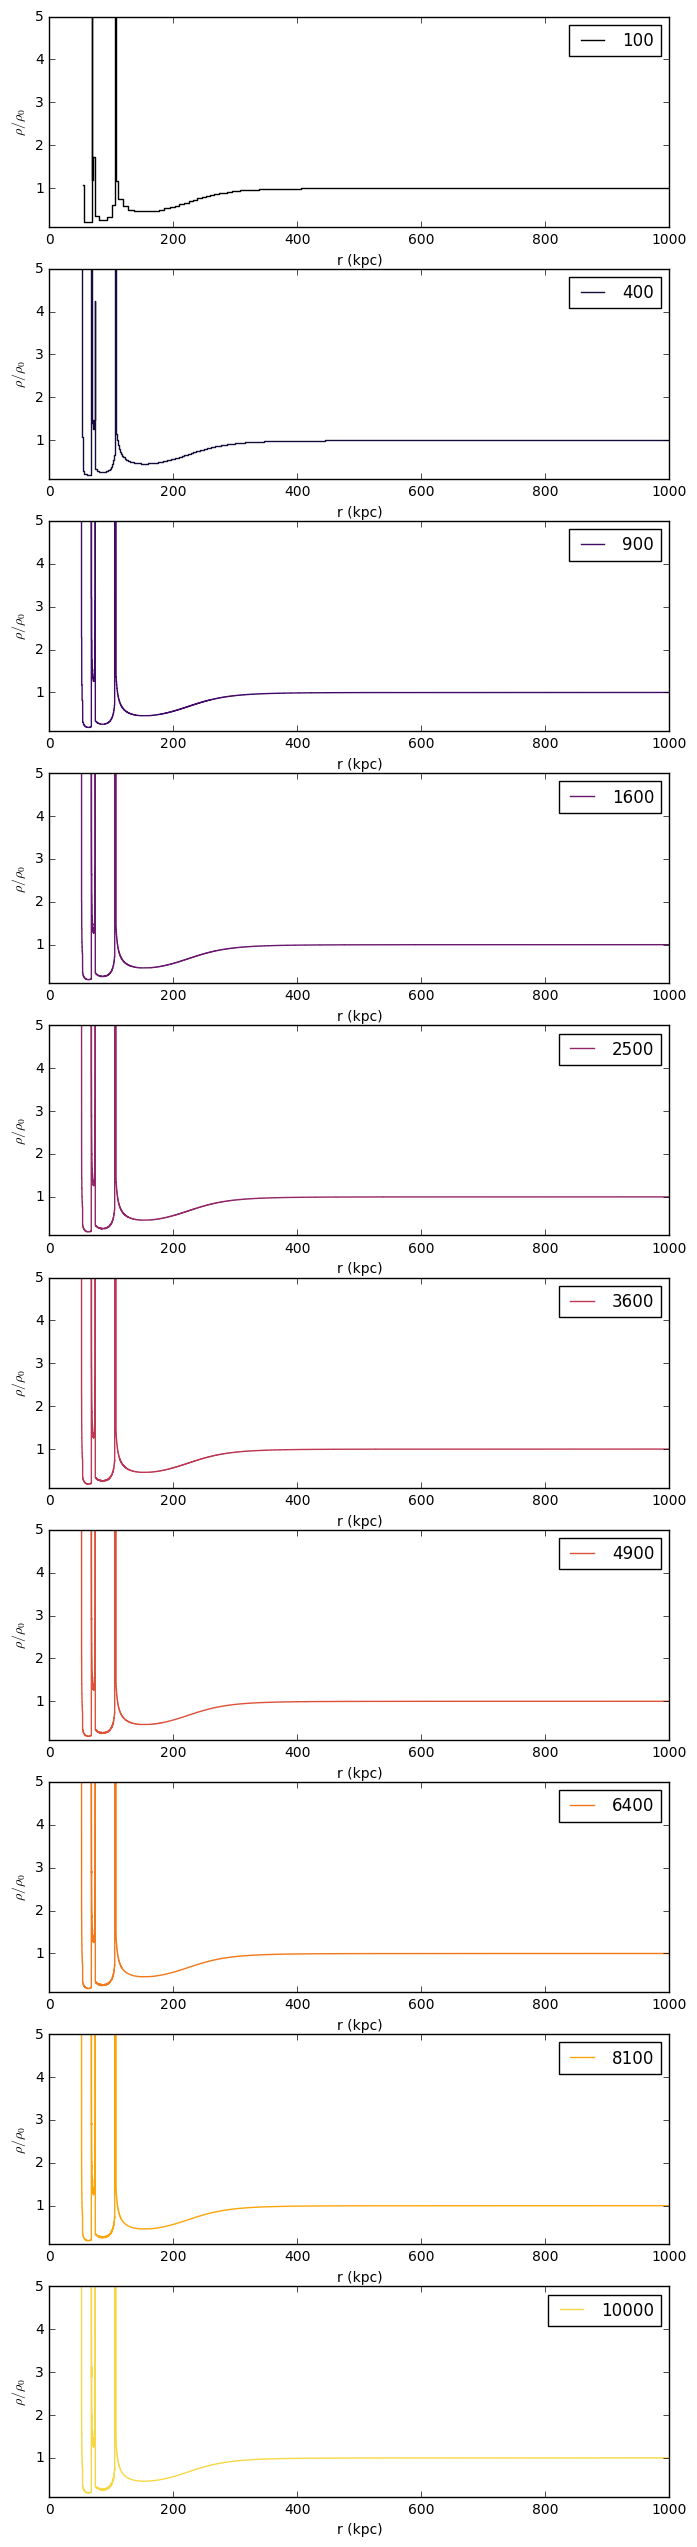

In [90]:
from scipy import integrate
#def intProfile(minR,maxR,nRads,deltaT,tMax): #runs simulation and calculates integral (probably messus up loads of other variables...)
#    smoothL=0.0002*maxR/np.sqrt(nRads)
#    dens=getDens(1,minR,maxR,nRads,smoothL,tMax,deltaT,1,-1)
#    #plotRads=np.linspace(minR,maxR,2000)
#    #plt.plot(plotRads,dens(plotRads),label=nRads)
#    #plt.legend()
#    def integrand(r):
#        return 4*np.pi*(r**2)*(dens(r)**2)
#    integral=integrate.quad(integrand, initR[0], initR[-1])
#    return integral[0]
def findInt(rads,shellM,minR,maxR): #finds the integral for a completed simulation
    def integrand(r):
        return 4*np.pi*(r**2)*findDens(rads,shellM,np.array([r]))
    integral=integrate.quad(integrand,minR,maxR)
    return integral[0]

def getInt(rads,dens,minR,maxR):
    sort=sortDens(rads,dens)
    sortR=sort[0]
    sortD=sort[1]
    low=np.argmin(sortR[(sortR>minR)])
    #print('low: ',low,' with radius: ',sortR[low])
    high=np.argmax(sortR[(sortR<maxR)])
    #print('high: ',high,' with rad: ',sortR[high])
    integral=0
    def integrand(r1,r2,D):
        return (4/3)*np.pi*((r2**3)-(r1**3))*(D**2)
    integral+=integrand(minR,sortR[low],sortD[low-1])
    integral+=integrand(sortR[high],maxR,sortD[high])
    for i in np.arange(low+1,high):
        integral+=integrand(sortR[i],sortR[i+1],sortD[i])
        #print("i: ",i," between: ",sortR[i]," and ",sortR[i+1])
        #print("with dens: ",sortD[i])
        #print("and int: ",integrand(sortR[i],sortR[i+1],dens[i]))
    return integral

#rads=pointR[timeSteps[7],:]
#dens=getDens(rads,pointM)
#minR=10
#maxR=2000
#print(getInt(rads,dens,minR,maxR)/((4/3)*0.1*np.pi*(maxR**3)))

fig=plt.figure(figsize=(8,32))
grid=gridspec.GridSpec(10,1)
cmap = matplotlib.cm.get_cmap('inferno')

res=np.linspace(10,100,10)**2
rhoSq=np.zeros(res.size)
rho0=10
minR=50
maxR=1000
dt=4e4 #in yrs
tStop=4e6 #in yrs
scCheck=1
for i in range(res.size):
    print("step ",i," with resolution: ",res[i])
    rads,shellM=getRads(rho0,minR,maxR,int(res[i]),tStop,dt,scCheck)
    getPlot(rads[-1,:],shellM,int(res[i]),i/res.size,0,i)
    dens=getDens(rads[-1,:],shellM)
    print("has max dens: ",np.max(dens)," at: ",rads[-1,np.argmax(dens)])
    #print("________radii: ",rads[-1,:])
    #print("dens: ",dens)
    rhoSq[i]=getInt(rads[-1,:],dens,10,200)
    print("has integral: ",rhoSq[i])
plt.show
#    testR=np.linspace(0.5,200,10000)
#    testDens=findDens(rads[timeSteps[0],:],shellM,testR)
#    rhoSq[i]=integrate.trapz(4*np.pi*(testR**2)*testDens,testR)/((4/3)*np.pi*(rho0)*(maxR**3))
    #rhoSq[i]=getInt(rads[timeSteps[0],:],shellM,minR,maxR)/((4/3)*np.pi*(rho0)*(maxR**3))
#    print("has integral: ",rhoSq[i])

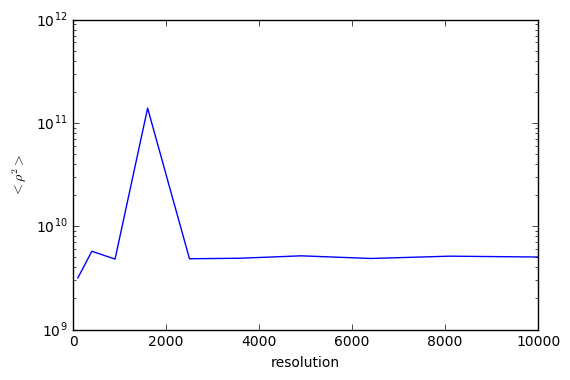

In [94]:
plt.semilogy(res,rhoSq)
plt.xlabel('resolution')
plt.ylabel(r'$<\rho^2>$')
#plt.savefig('resolutionStudy.png')
#plt.close